In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!pip uninstall -y numpy tensorflow

Found existing installation: numpy 1.23.5
Uninstalling numpy-1.23.5:
  Successfully uninstalled numpy-1.23.5
Found existing installation: tensorflow 2.12.0
Uninstalling tensorflow-2.12.0:
  Successfully uninstalled tensorflow-2.12.0


In [2]:
!pip install scikit-learn==1.2.2 imbalanced-learn==0.10.1 tensorflow==2.12.0

  Using cached tensorflow-2.12.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.4 kB)
  Using cached numpy-2.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
  Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.3 kB)
Using cached tensorflow-2.12.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (586.0 MB)
Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mlxtend 0.23.4 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.2 which is incompatible.
tensorflow-text 2.18.1 requires tensorflow<2.19,>=2.18.0, but you have tensorflow 2.12.0 which is incompatible.
scikit-image 0.25.2 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
bigframe

In [3]:

!pip install numpy==1.23.5

In [8]:
!pip install numpy.rec

ERROR: Could not find a version that satisfies the requirement numpy.rec (from versions: none)
ERROR: No matching distribution found for numpy.rec


In [4]:
# Cell 1: Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from wordcloud import WordCloud
from xgboost import XGBClassifier
import tensorflow as tf
import pickle
import os
from warnings import simplefilter
simplefilter("ignore")

# Download required NLTK data
nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [5]:
# Cell 2: Helper Functions
def get_test_scores(model_name, preds, y_test_data):
    metrics = {
        'model': model_name,
        'accuracy': accuracy_score(y_test_data, preds),
        'precision': precision_score(y_test_data, preds, average='macro'),
        'recall': recall_score(y_test_data, preds, average='macro'),
        'f1': f1_score(y_test_data, preds, average='macro')
    }
    return pd.DataFrame([metrics])

def preprocess_text(data):
    data_out = data.str.replace('\n', ' ')
    punct = "\n\r" + string.punctuation
    data_out = data_out.str.translate(str.maketrans('', '', punct))
    data_out = data_out.apply(lambda x: x.lower())
    return data_out



In [6]:
# Cell 3: Load and Prepare Data
df = pd.read_csv('/content/bbc_text_cls.csv')
inputs = df['text']
labels = df['labels']
X_train, X_test, y_train, y_test = train_test_split(inputs, labels, random_state=42)

print("Dataset shape:", df.shape)
print("\nSample data:")
print(df.head(2))



Dataset shape: (2225, 2)

Sample data:
                                                text    labels
0  Ad sales boost Time Warner profit\n\nQuarterly...  business
1  Dollar gains on Greenspan speech\n\nThe dollar...  business


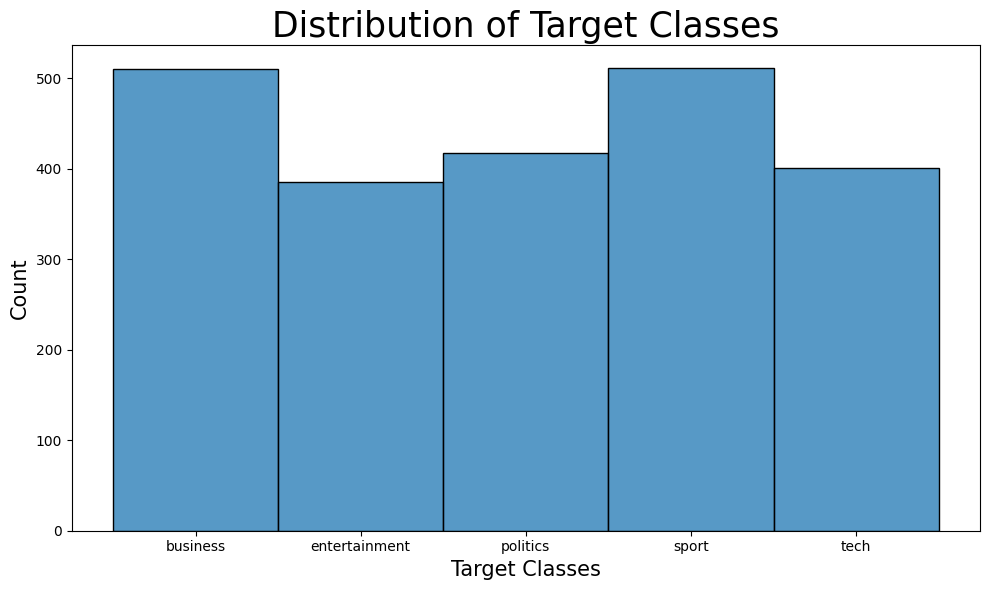

In [7]:
# Cell 4: Data Visualization - Class Distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=labels)
plt.title('Distribution of Target Classes', fontsize=25)
plt.xlabel('Target Classes', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.tight_layout()
plt.show()



Mean words in sport articles: 329.3
Mean words in business articles: 328.9
Mean words in politics articles: 454.0
Mean words in entertainment articles: 330.6
Mean words in tech articles: 502.7


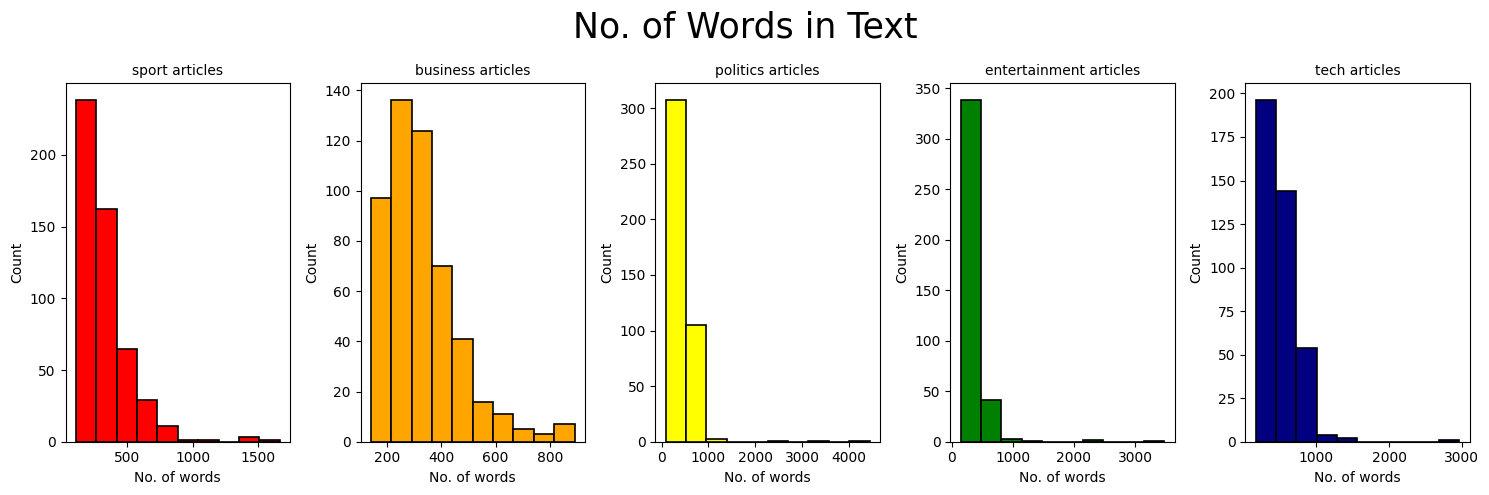

In [8]:
# Cell 5: Data Visualization - Word Distribution
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(ncols=5, figsize=(15, 5))
categories = ['sport', 'business', 'politics', 'entertainment', 'tech']
colors = ['red', 'orange', 'yellow', 'green', 'navy']

for cat, color, ax in zip(categories, colors, [ax1, ax2, ax3, ax4, ax5]):
    word_len = df[df['labels']==cat]['text'].str.split().map(lambda x: len(x))
    ax.hist(word_len, color=color, edgecolor='black', linewidth=1.2)
    ax.set_title(f'{cat} articles', size=10)
    ax.set_xlabel('No. of words', size=10)
    ax.set_ylabel('Count', size=10)
    print(f'Mean words in {cat} articles: {word_len.mean():.1f}')

plt.suptitle("No. of Words in Text", size=25)
plt.tight_layout()
plt.show()



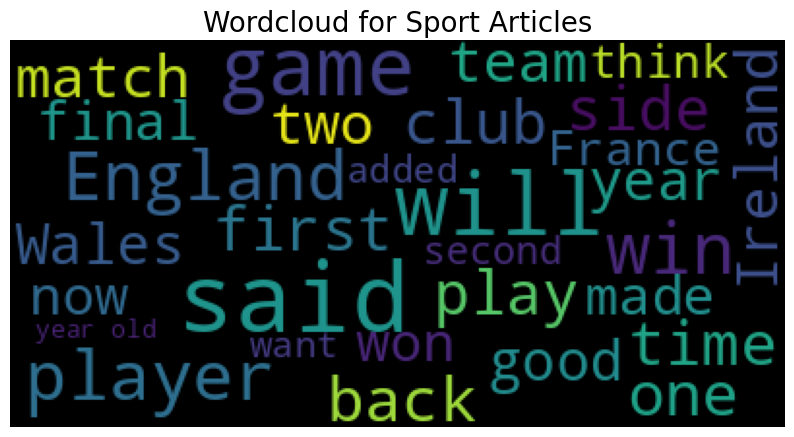

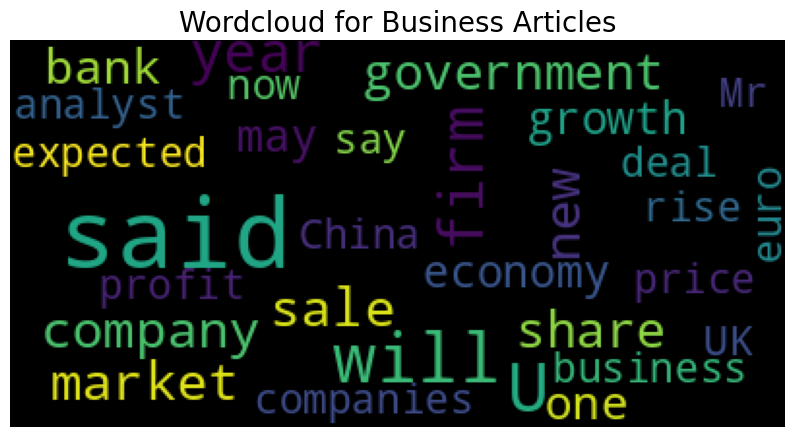

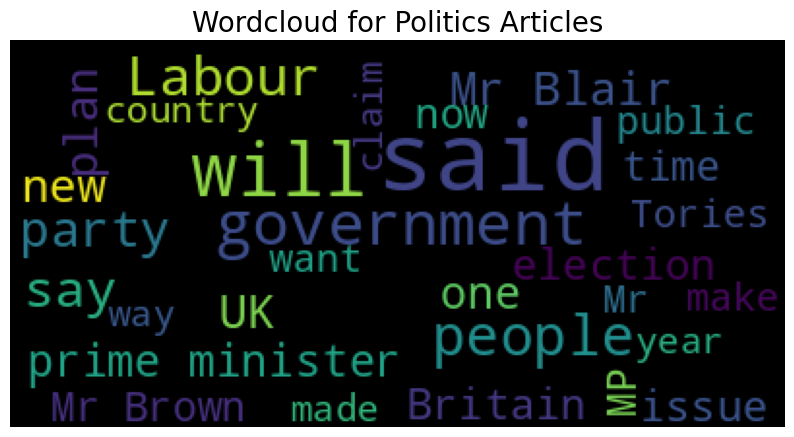

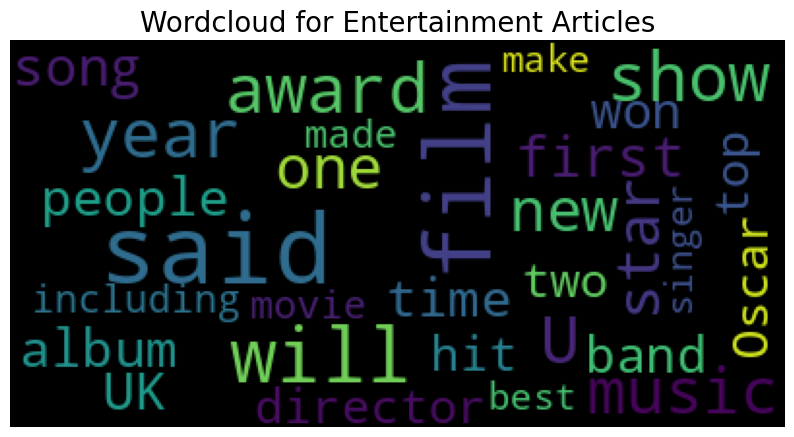

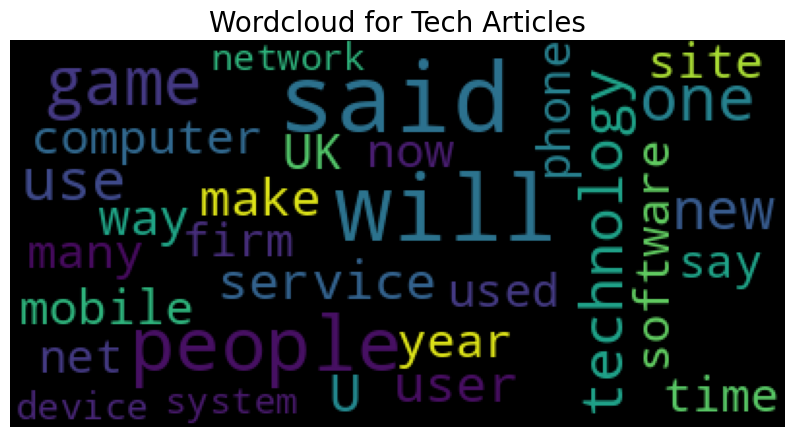

In [9]:
# Cell 6: Generate WordClouds
for category in categories:
    text = ' '.join(df[df['labels']==category]['text'])
    wordcloud = WordCloud(max_font_size=50, max_words=30).generate(text)

    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(f"Wordcloud for {category.title()} Articles", fontsize=20)
    plt.show()



In [10]:
# Cell 7: Text Preprocessing
X_train_processed = preprocess_text(X_train)
X_test_processed = preprocess_text(X_test)





MultinomialNB Results:
           model  accuracy  precision    recall        f1
0  MultinomialNB  0.967684    0.96683  0.968216  0.967202


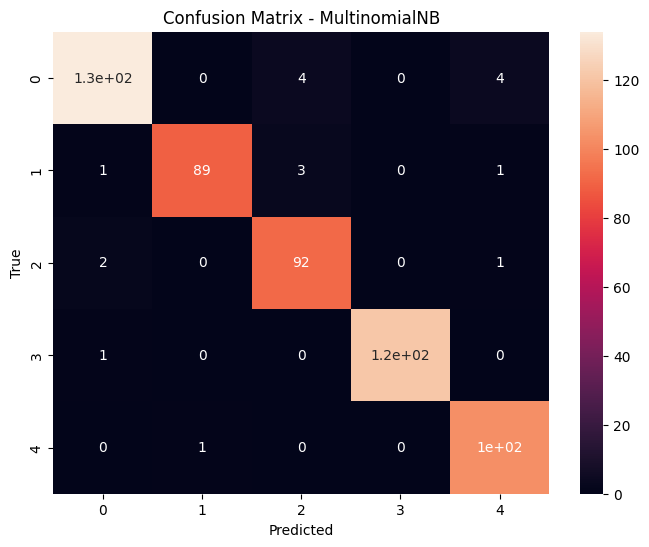

In [11]:
# Cell 8: Train and Evaluate MultinomialNB with CountVectorizer
vectorizer = CountVectorizer(stop_words='english')
X_train_cv = vectorizer.fit_transform(X_train_processed)
X_test_cv = vectorizer.transform(X_test_processed)

mnb = MultinomialNB()
mnb.fit(X_train_cv, y_train)
mnb_preds = mnb.predict(X_test_cv)

# Save MultinomialNB model and vectorizer
with open('mnb_model.pkl', 'wb') as f:
    pickle.dump((mnb, vectorizer), f)

mnb_results = get_test_scores('MultinomialNB', mnb_preds, y_test)
print("\nMultinomialNB Results:")
print(mnb_results)

# Plot confusion matrix for MultinomialNB
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, mnb_preds)
sns.heatmap(cm, annot=True)
plt.title('Confusion Matrix - MultinomialNB')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()




XGBoost Results:
     model  accuracy  precision    recall        f1
0  XGBoost  0.953321   0.952914  0.954219  0.953181


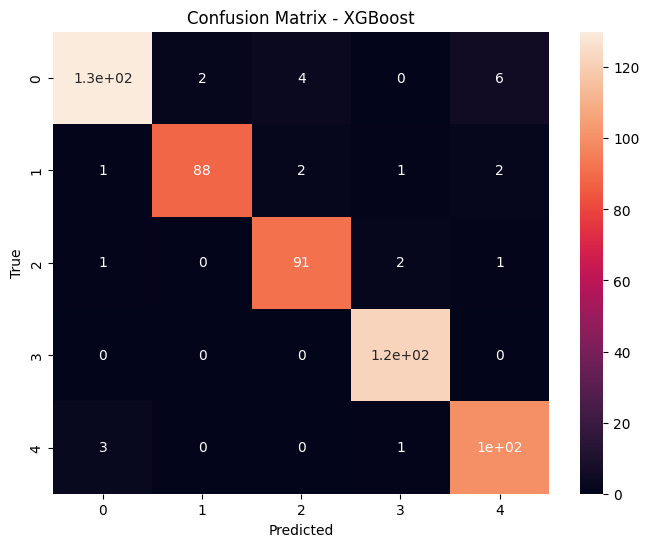

In [12]:
# Cell 9: Train and Evaluate XGBoost with TF-IDF
tfidf = TfidfVectorizer(stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train_processed)
X_test_tfidf = tfidf.transform(X_test_processed)

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

xgb = XGBClassifier(objective='binary:logistic', random_state=42)
xgb.fit(X_train_tfidf, y_train_encoded)
xgb_preds = xgb.predict(X_test_tfidf)

# Save XGBoost model and TF-IDF vectorizer
with open('xgb_model.pkl', 'wb') as f:
    pickle.dump((xgb, tfidf, le), f)

xgb_results = get_test_scores('XGBoost', xgb_preds, y_test_encoded)
print("\nXGBoost Results:")
print(xgb_results)

# Plot confusion matrix for XGBoost
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test_encoded, xgb_preds)
sns.heatmap(cm, annot=True)
plt.title('Confusion Matrix - XGBoost')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()




Random Forest Results:
           model  accuracy  precision    recall        f1
0  Random Forest  0.960503   0.964062  0.958456  0.960992


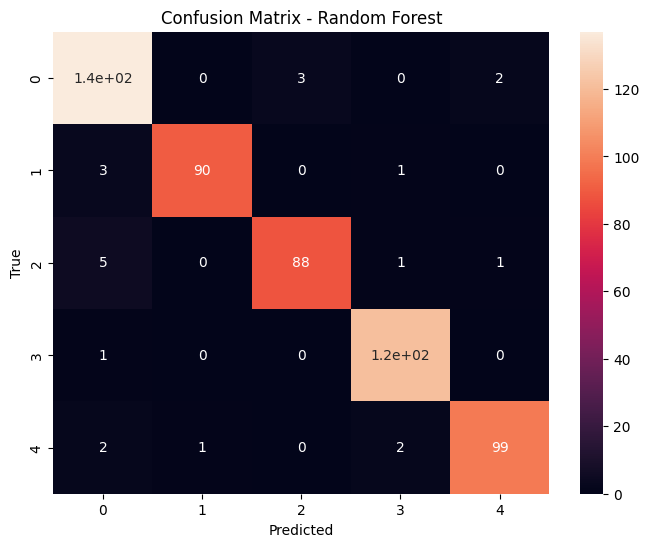

In [13]:
# Cell 10: Train and Evaluate Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_tfidf, y_train_encoded)
rf_preds = rf.predict(X_test_tfidf)

# Save Random Forest model
with open('rf_model.pkl', 'wb') as f:
    pickle.dump(rf, f)

rf_results = get_test_scores('Random Forest', rf_preds, y_test_encoded)
print("\nRandom Forest Results:")
print(rf_results)

# Plot confusion matrix for Random Forest
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test_encoded, rf_preds)
sns.heatmap(cm, annot=True)
plt.title('Confusion Matrix - Random Forest')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()



In [14]:
# Cell 11: Prepare Data for CNN
df['targets'] = df['labels'].astype("category").cat.codes
df_train, df_test = train_test_split(df, test_size=0.2)
df_train, df_valid = train_test_split(df_train, test_size=0.2)

for data in [df_train, df_valid, df_test]:
    data['text'] = preprocess_text(data['text'])



In [15]:
# Cell 12: CNN Tokenization and Sequence Preparation
MAX_VOCAB_SIZE = 2000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df_train['text'])

sequences_train = tokenizer.texts_to_sequences(df_train['text'])
sequences_valid = tokenizer.texts_to_sequences(df_valid['text'])
sequences_test = tokenizer.texts_to_sequences(df_test['text'])

data_train = tf.keras.preprocessing.sequence.pad_sequences(sequences_train)
T = data_train.shape[1]
data_valid = tf.keras.preprocessing.sequence.pad_sequences(sequences_valid, maxlen=T)
data_test = tf.keras.preprocessing.sequence.pad_sequences(sequences_test, maxlen=T)



In [16]:
# Cell 13: Build and Train CNN Model
V = len(tokenizer.word_index)
D = 50
K = df['targets'].max() + 1

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(T,)),
    tf.keras.layers.Embedding(V+1, D),
    tf.keras.layers.Conv1D(32, 3, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(K, activation='softmax')
])

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy']
)

callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_accuracy',
        patience=4,
        factor=0.5,
        min_lr=0.0000001
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'best_model.keras',
        save_best_only=True,
        monitor='val_accuracy',
        mode='max'
    )
]

history = model.fit(
    data_train, df_train['targets'],
    epochs=10,
    validation_data=(data_valid, df_valid['targets']),
    callbacks=callbacks
)

# Save tokenizer
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)



Epoch 1/10
45/45 [==============================] - 11s 235ms/step - loss: 1.6070 - accuracy: 0.2275 - val_loss: 1.6048 - val_accuracy: 0.2528 - lr: 0.0010
Epoch 2/10
45/45 [==============================] - 8s 187ms/step - loss: 1.5978 - accuracy: 0.2430 - val_loss: 1.5938 - val_accuracy: 0.2303 - lr: 0.0010
Epoch 3/10
45/45 [==============================] - 9s 194ms/step - loss: 1.5738 - accuracy: 0.3272 - val_loss: 1.5592 - val_accuracy: 0.4017 - lr: 0.0010
Epoch 4/10
45/45 [==============================] - 7s 159ms/step - loss: 1.5243 - accuracy: 0.4073 - val_loss: 1.4910 - val_accuracy: 0.5730 - lr: 0.0010
Epoch 5/10
45/45 [==============================] - 9s 190ms/step - loss: 1.4587 - accuracy: 0.4586 - val_loss: 1.4013 - val_accuracy: 0.6433 - lr: 0.0010
Epoch 6/10
45/45 [==============================] - 7s 156ms/step - loss: 1.3639 - accuracy: 0.5239 - val_loss: 1.2978 - val_accuracy: 0.6573 - lr: 0.0010
Epoch 7/10
45/45 [==============================] - 8s 179ms/step - l

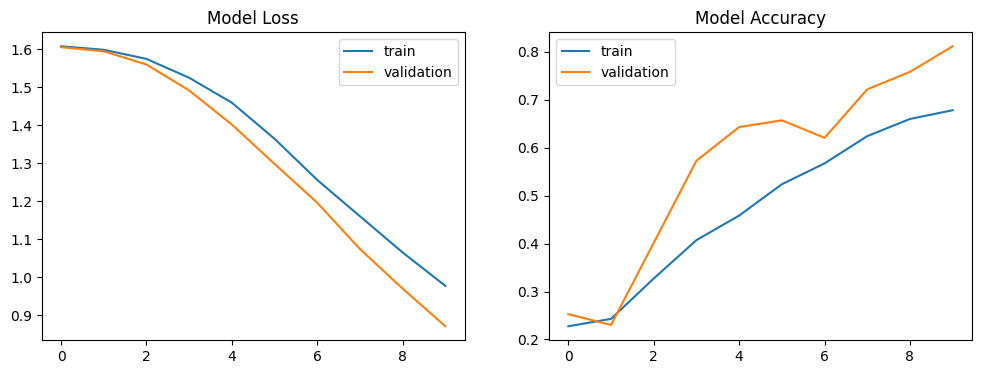

In [17]:
# Cell 14: Plot CNN Training History
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Model Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Model Accuracy')
plt.legend()
plt.show()



In [18]:
# Cell 15: Evaluate CNN Model
cnn_score = model.evaluate(data_test, df_test['targets'], verbose=0)
print("\nCNN Model Results:")
print(f"Test Loss: {cnn_score[0]:.4f}")
print(f"Test Accuracy: {cnn_score[1]:.4f}")




CNN Model Results:
Test Loss: 0.8765
Test Accuracy: 0.8562


In [19]:
# Cell 16: Example Usage of Saved Models (Run this after models are trained)

# Example text to classify
#text = "The Sao Paulo Grand Prix brought drama with McLaren’s Lando Norris narrowly avoiding a penalty due to an aborted start. Max Verstappen's dominant performance keeps his title aspirations strong, despite some criticisms of his team’s strategic calls"
#text = input(" ")
# Preprocess text
text_processed = preprocess_text(pd.Series([text]))[0]

# Load and use MultinomialNB model
with open('mnb_model.pkl', 'rb') as f:
    mnb, cv = pickle.load(f)
mnb_pred = mnb.predict(cv.transform([text_processed]))[0]

# Load and use XGBoost model
with open('xgb_model.pkl', 'rb') as f:
    xgb, tfidf, le = pickle.load(f)
xgb_pred = le.inverse_transform([xgb.predict(tfidf.transform([text_processed]))[0]])[0]

# Load and use Random Forest model
with open('rf_model.pkl', 'rb') as f:
    rf = pickle.load(f)
rf_pred = le.inverse_transform([rf.predict(tfidf.transform([text_processed]))[0]])[0]

# Load and use CNN model
cnn_model = tf.keras.models.load_model('best_model.keras')
with open('tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

sequence = tokenizer.texts_to_sequences([text_processed])
padded = tf.keras.preprocessing.sequence.pad_sequences(sequence, maxlen=T)
cnn_pred = le.inverse_transform([np.argmax(cnn_model.predict(padded))])[0]

print(f"MultinomialNB prediction: {mnb_pred}")
print(f"XGBoost prediction: {xgb_pred}")
print(f"Random Forest prediction: {rf_pred}")
print(f"CNN prediction: {cnn_pred}")


1/1 [==============================] - 0s 222ms/step
MultinomialNB prediction: tech
XGBoost prediction: tech
Random Forest prediction: tech
CNN prediction: tech


In [24]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 91.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 131.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 8.1 MB/s eta 0:00:00


In [29]:
%%writefile news.py
import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# Streamlit UI setup
st.set_page_config(page_title="News Categorization", layout="wide")
st.title("📰 News Categorization App")

# File upload
uploaded_file = st.file_uploader("Upload your news dataset (CSV)", type=["csv"])

if uploaded_file:
    # Load dataset
    df = pd.read_csv(uploaded_file)
    st.subheader("Data Preview")
    st.dataframe(df.head())

    # Check required columns
    if 'text' not in df.columns or 'labels' not in df.columns:
        st.error("CSV must contain 'text' and 'labels' columns.")
    else:
        # Visualize category distribution
        st.subheader("Category Distribution")
        fig, ax = plt.subplots()
        df['labels'].value_counts().plot(kind='bar', ax=ax)
        st.pyplot(fig)

        # Preprocess text
        vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
        X = vectorizer.fit_transform(df['text'])
        y = df['labels']

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Train model
        model = MultinomialNB()
        model.fit(X_train, y_train)

        # Evaluate
        st.subheader("Model Evaluation")
        y_pred = model.predict(X_test)
        st.text(classification_report(y_test, y_pred))

        # Confusion Matrix
        fig, ax = plt.subplots(figsize=(10, 6))
        ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, cmap='Blues')
        st.pyplot(fig)

        # Text input for prediction
        st.subheader("Try it Yourself")
        user_input = st.text_area("Enter a news article or snippet")
        if st.button("Classify"):
            if user_input.strip():
                input_transformed = vectorizer.transform([user_input])
                prediction = model.predict(input_transformed)
                st.success(f"Predicted Category: {prediction[0]}")
            else:
                st.warning("Please enter some text.")
else:
    st.info("Awaiting CSV file upload. Please upload a dataset with 'text' and 'labels' columns.")


Overwriting news.py


In [30]:
!streamlit run news.py &>/content/logs.txt & curl ipv4.icanhazip.com

34.19.16.218


In [ ]:
!npx localtunnel --port 8501


⠙⠹⠸⠼⠴your url is: https://yellow-forks-march.loca.lt
